# Cleanup
Here we clean up the Kuy production data

------------
# Contents
------------
- [VOT visualization](#VOT-visualization) <br>
- [Data cleanup](#Data-cleanup) <br>
- [Time normalization](#Time-normalization) <br>
- [Save](#Save) <br>

In [1]:
import os
from datetime import datetime

import pandas as pd
import numpy as np
from scipy.signal import medfilt
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale = 1.5, style = 'whitegrid')

### Measures we are interested in

In [2]:
measures = ['f0', 'H1c', 'H1H2c', 'H1A1c', 'H1A2c', 'H1A3c', 'CPP', 'F1']

### Functions

In [3]:
def hz_to_semi(hz, base = 75):
    '''
    Converts from Hertz to semitones based on the formula
    n = 12 × log2 (hz / base)
    '''
    return(12*np.log2(hz/base))

def pct_info(df_old, df_new, return_pct = False, print_info = True, word_info = False):
    '''
    Function to print info about removal from dataset
    (1) Tokens in original dataset
    (2) Tokens in new dataset
    (3) Tokens and percent removed
    
    - If return_pct == True, return the percentage
    - If print_info == True, print all info
    - If word_info == True, show word info too
    '''
    n_old = len(df_old)
    n_new = len(df_new)
    diff = n_old - n_new
    
    if word_info == True:
        
        n_w_old = df_old['Filename'].nunique()
        n_w_new = df_new['Filename'].nunique()
        diff_w = n_w_old - n_w_new
        
        print('Files produced reduced from', n_w_old, 'to', n_w_new, '(', diff_w, 'files removed,', round(diff_w/n_w_old*100, 2), '% of the dataset )')
    
    if print_info == True:
        
        print('Tokens reduced from', n_old, 'to', n_new, '(', diff, 'tokens removed,', round(diff/n_old*100, 2), '% of the dataset )')
    
    if return_pct == True:
        
        return(round(diff/n_old*100, 2))

#####
#####
#####

def remove_zeros(df, cols, distrib = False, **kwargs):
    '''
    Takes a dataframe and columns to look for zero and N/A values
    Removes rows with zeros in those columns
    '''
    
    print('- Removing zeroes... -')
    
    df_new = df
    
    for c in cols:
    
        df_new = df_new[df_new[c] != 0]
        df_new = df_new[-df_new[c].isnull()]

        # If true, show percentage of 0 values for each measure
        if distrib == True:
            
            print('Number of 0 values for', c, ':', len(df[df[c] == 0]), '(', round(len(df[df[c] == 0])/len(df)*100, 2), '% )')
    
    print()
    pct_info(df, df_new, **kwargs)
    
    return(df_new.reset_index(drop = True))


#####
#####
#####

def normalize(df, grouping, cols):
    '''
    Takes a dataframe, grouping to normalize by, columns to normalize 
    and adds mean, sd, z-score, and normalized scores
    
    z-score = (x - mean_group)/sd_group
    norm = mean_group + z-score * sd_group
    '''

    print('- Normalizing data by', ', '.join(grouping), '... -')
    
    start = datetime.now()
    
    for c in cols:
    
        # Get means and SDs
        sumstats = df.groupby(grouping)[c].agg(['mean', 'std']).rename(columns = {'mean': c + '_mean', 'std': c + '_sd'})
        
        df = df.merge(sumstats, on = grouping)

        df[c + '_z'] = (df[c] - df[c + '_mean'])/(df[c + '_sd'])
    
    print('Time taken to normalize:', str(datetime.now() - start))
        
    return(df)


#####
#####
#####

def remove_outliers(df, cutoff, z_cols, distrib = True, **kwargs):
    '''
    Takes dataframe, cutoff, and columns with z-scores and removes values above a certain SD value
    '''
    
    print('- Removing outliers... -')
    
    df_new = df

    for c in z_cols:

        df_new = df_new[abs(df_new[c]) <= cutoff].reset_index(drop = True)
        
        # If true, show percentage of values over cutoff for each measure
        if distrib == True:
            
            print('Number of values over', cutoff, 'SDs for', c, ':', len(df[abs(df[c]) > cutoff]), '(', round(len(df[abs(df[c]) > cutoff])/len(df)*100, 2), '% )')
        
    print()
    
    pct_info(df, df_new, **kwargs)
    
    return(df_new)


#####
#####
#####

def categorical_kde_plot(
    df,
    variable,
    category,
    category_order=None,
    horizontal=False,
    rug=True,
    figsize=None,
    colors=sns.color_palette()
):
    """Draw a categorical KDE plot

    Parameters
    ----------
    df: pd.DataFrame
        The data to plot
    variable: str
        The column in the `df` to plot (continuous variable)
    category: str
        The column in the `df` to use for grouping (categorical variable)
    horizontal: bool
        If True, draw density plots horizontally. Otherwise, draw them
        vertically.
    rug: bool
        If True, add also a sns.rugplot.
    figsize: tuple or None
        If None, use default figsize of (7, 1*len(categories))
        If tuple, use that figsize. Given to plt.subplots as an argument.
    """
    if category_order is None:
        categories = list(df[category].unique())
    else:
        categories = category_order[:]

    fig, axes = plt.subplots(
        nrows=len(categories) if horizontal else 1,
        ncols=1 if horizontal else len(categories),
        figsize=figsize[::-1] if not horizontal else figsize,
        sharex=horizontal,
        sharey=not horizontal,
    )

    for i, (cat, ax) in enumerate(zip(categories, axes)):
        g = sns.kdeplot(
            data=df[df[category] == cat],
            x=variable if horizontal else None,
            y=None if horizontal else variable,
            # kde kwargs
            bw_adjust=0.5,
            clip_on=False,
            fill=True,
            alpha=1,
            linewidth=1.5,
            ax=ax,
            color=colors[i],
            edgecolor='black'
        )

        keep_variable_axis = (i == len(fig.axes) - 1) if horizontal else (i == 0)

        if rug:
            sns.rugplot(
                data=df[df[category] == cat],
                x=variable if horizontal else None,
                y=None if horizontal else variable,
                ax=ax,
                color="black",
                height=0.025 if keep_variable_axis else 0.04,
            )

        _format_axis(
            ax,
            cat,
            horizontal,
            keep_variable_axis=keep_variable_axis,
        )

    plt.tight_layout()
    
    return(fig, axes)


def _format_axis(ax, category, horizontal=False, keep_variable_axis=True):

    # Remove the axis lines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if horizontal:
        ax.set_ylabel(None)
        lim = ax.get_ylim()
        ax.set_yticks([(lim[0] + lim[1]) / 2])
        ax.set_yticklabels([category])
        if not keep_variable_axis:
            ax.get_xaxis().set_visible(True)
            ax.spines["bottom"].set_visible(False)
        ax.grid(b = False, which = 'major', axis = 'y')
    else:
        ax.set_xlabel(None)
        lim = ax.get_xlim()
        ax.set_xticks([(lim[0] + lim[1]) / 2])
        ax.set_xticklabels([category])
        if not keep_variable_axis:
            ax.get_yaxis().set_visible(False)
            ax.spines["left"].set_visible(False)

## Read in file

In [4]:
# Read in CSV file
full_df = pd.read_csv('../0_data/output.txt', sep = '\t')

# Drop unnamed
full_df = full_df.drop([c for c in full_df.columns if 'Unnamed' in c], axis = 1)

# Split filename into sp, word, round, order
full_df = full_df.join(full_df['Filename'].str.split('_', expand=True).rename(columns={0:'sp', 1:'word', 2:'round', 3:'order'}))

# Change speaker to just the number
# Get rid of .mat in order
# Change ms time to starting from 0 to visualize meaningfully
# Add duration
full_df['sp'] = full_df['sp'].str.split('sp').str[-1].astype(int)
full_df['order'] = full_df['order'].str.replace('.mat', '', regex = False)
full_df['ms'] = full_df['t_ms'] - np.round(full_df['seg_Start'])
full_df['duration'] = full_df['seg_End'] - full_df['seg_Start']

# Rename some columns
full_df = full_df.rename(columns = {'strF0':'f0', 'pF1':'F1', 'pF2':'F2', 'pF3':'F3'})

---
# VOT visualization
---
- [Contents](#Contents) <br>
- [Data cleanup](#Data-cleanup) <br>
- [Time normalization](#Time-normalization) <br>
- [Save](#Save) <br>
<br>
- Get stimuli and create categories
- Merge the info to the VOT df and get duration for each file
- Visualize

In [5]:
stim = pd.read_csv('../0_data/kuy-production-stimuli.csv').fillna('')

stim['vot_type'] = (stim['aspiration'] + ' ' + stim['register']).str.strip()

In [6]:
# Only lines with VOT
vot = full_df.query('Label == "VOT"').merge(stim, on = 'word')

# Get duration for each file
vot_sum = vot.groupby(['Filename', 'vot_type']).duration.mean().reset_index()

# Summary statistics
vot_sum.groupby('vot_type').duration.agg(['mean', 'std', 'count'])

,mean,std,count
vot_type,,,
aspirated modal,66.334108,31.129578,342
breathy,26.753331,15.862125,2262
unaspirated modal,16.891658,8.679648,1938


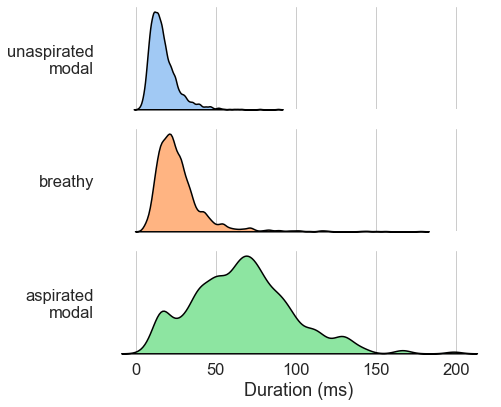

In [7]:
fig, axs = categorical_kde_plot(
        df = vot_sum,
        figsize = (8,6),
        rug = False,
        variable = 'duration',
        category = 'vot_type',
        category_order = ['unaspirated modal', 'breathy', 'aspirated modal'],
        horizontal = True,
        colors = sns.color_palette('pastel'),
    )

for i, label in enumerate([['unaspirated\nmodal'], ['breathy'], ['aspirated\nmodal']]):

    axs.flat[i].set_yticklabels(label)
    if i == 2:
        axs.flat[i].set_xlabel('Duration (ms)')
        
sns.despine(left = True, bottom = True)

plt.savefig('vot.png', dpi = 300, bbox_inches = 'tight')

---
# Data cleanup
---
- [Contents](#Contents) <br>
- [VOT visualization](#VOT-visualization) <br>
- [Time normalization](#Time-normalization) <br>
- [Save](#Save) <br>

In [8]:
# Get vowel info and get vowel quality and register
df = full_df[full_df['Label'] != 'VOT'].reset_index(drop = True)

df['register'] = df['Label'].apply(lambda lab: 'breathy' if lab[-1] == 'H' else 'modal')
df['vowelqual'] = df['Label'].apply(lambda lab: lab.replace('H', ''))

## 3 things to adjust
1) Median filter to smooth out sudden jumps and so that zeros are not unnecessarily removed
1) Get rid of zeroes
1) Outlier points by sp, vowel quality, and voice quality

### (1) Median filter all the measures

In [9]:
for m in measures:
    df[m + '_mf'] = medfilt(df[m], kernel_size = 15)
    
measures_mf = [m + '_mf' for m in measures]

### (2) Remove zeros

In [10]:
df_nozeros = remove_zeros(df = df, cols = measures_mf, distrib = True, word_info = True)

- Removing zeroes... -
Number of 0 values for f0_mf : 0 ( 0.0 % )
Number of 0 values for H1c_mf : 619 ( 0.06 % )
Number of 0 values for H1H2c_mf : 513 ( 0.05 % )
Number of 0 values for H1A1c_mf : 714 ( 0.07 % )
Number of 0 values for H1A2c_mf : 701 ( 0.07 % )
Number of 0 values for H1A3c_mf : 800 ( 0.07 % )
Number of 0 values for CPP_mf : 0 ( 0.0 % )
Number of 0 values for F1_mf : 0 ( 0.0 % )

Files produced reduced from 5125 to 5125 ( 0 files removed, 0.0 % of the dataset )
Tokens reduced from 1077538 to 1076510 ( 1028 tokens removed, 0.1 % of the dataset )


### (3) Normalize and remove outliers

In [11]:
#####
# Normalize by speaker, vowel, and register
#####
z_group = ['sp', 'vowelqual', 'register']
z_cutoff = 3

print()
df_nozeros = normalize(df = df_nozeros, grouping = z_group, cols = measures_mf)

print('Done calculating z-values!')

# Remove outliers
print()
df_nooutliers = remove_outliers(df = df_nozeros, cutoff = z_cutoff, 
                                z_cols = [m + '_z' for m in measures_mf], 
                                word_info = True, distrib = True)

print()
print('Outliers removed!')


- Normalizing data by sp, vowelqual, register ... -
Time taken to normalize: 0:00:05.521381
Done calculating z-values!

- Removing outliers... -
Number of values over 3 SDs for f0_mf_z : 6526 ( 0.61 % )
Number of values over 3 SDs for H1c_mf_z : 19643 ( 1.82 % )
Number of values over 3 SDs for H1H2c_mf_z : 9006 ( 0.84 % )
Number of values over 3 SDs for H1A1c_mf_z : 10049 ( 0.93 % )
Number of values over 3 SDs for H1A2c_mf_z : 6054 ( 0.56 % )
Number of values over 3 SDs for H1A3c_mf_z : 8453 ( 0.79 % )
Number of values over 3 SDs for CPP_mf_z : 4863 ( 0.45 % )
Number of values over 3 SDs for F1_mf_z : 12810 ( 1.19 % )

Files produced reduced from 5125 to 5125 ( 0 files removed, 0.0 % of the dataset )
Tokens reduced from 1076510 to 1020504 ( 56006 tokens removed, 5.2 % of the dataset )

Outliers removed!


---
# Time normalization
---
- [Contents](#Contents) <br>
- [VOT visualization](#VOT-visualization) <br>
- [Data cleanup](#Data-cleanup) <br>
- [Save](#Save) <br>

### Convert to semitones
- Let's reduce the dataset to the median-filtered columns and rename as the original names
- Then bin points into time intervals
- Then get mean for each timepoint in each file

In [12]:
df_rename = df_nooutliers[['Filename', 'sp', 'word', 'Label', 'register', 'vowelqual', 'ms', 'duration', 'round', 'order'] + measures_mf]
df_rename = df_rename.rename(columns = dict(zip(measures_mf, measures)))

for fno in ['f0', 'F1']:
    df_rename[fno + '_semitones'] = hz_to_semi(df_rename[fno], base = 75)

In [13]:
# Number of time intervals
tps = 20

df_rename['time'] = df_rename.groupby('Filename')['ms'].apply(pd.cut, bins = tps, labels = False) + 1
df_rename['time_interval'] = df_rename.groupby('Filename')['ms'].apply(pd.cut, bins = tps)

In [14]:
# Group by filename and time
keep = ['Filename', 'sp', 'word', 'Label', 'register', 'vowelqual', 'duration', 'round', 'order', 'time_interval', 'time']

df_timenorm = df_rename.groupby(keep)[measures + ['f0_semitones', 'F1_semitones']].mean().reset_index()

---
# Save
---
- [Contents](#Contents) <br>
- [VOT visualization](#VOT-visualization) <br>
- [Data cleanup](#Data-cleanup) <br>
- [Time normalization](#Time-normalization) <br>
<br>

In [15]:
df_timenorm.to_csv('../0_data/kuy-production-clean.csv', index = False)